In [1]:
import os
import pandas as pd
pd.options.display.max_columns = 150
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

# Importing and Processing Data

In [2]:
# on board survey
obs = pd.read_csv(r'../data/on_board_survey/TPS_Model_Version_PopulationSim_Weights2021-07-27.csv')
                  
# ancillary data -- used for determining inbound vs outbound
ancillary_df = pd.read_csv(r'../data/on_board_survey/ancillary_data/ancillary_variables.csv')

# crosswalks
geo_xwalk = pd.read_csv(r'../data/geo_xwalks/geographicCWalk.csv')

C:\Users\david.hensle\.conda\envs\mtc_omx\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (0,7,16,17,24,25,26,35,38,39,43,46,47,48,49,50,51,52,63,64,65,66,67,95,96,97,98,99) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# skim
skim_matrix = pd.read_csv(r'../data/SOV_DIST_MD_HWYSKM.csv')

### Merging ancillary data and determining outbound vs inbound for tour access mode

In [4]:
assert all(obs['access_mode_model'].isin(['walk', 'pnr', 'knr', 'tnc'])), "Invalid access mode"

assert all(obs['egress_mode_model'].isin(['walk', 'pnr', 'knr', 'tnc'])), "Invalid egress mode"

#### Option 1: Determining tour mode by finding which leg was outbound

In [5]:
# ancillary_df['unique_ID'] = ancillary_df['Unique_ID'].str.replace('-', '_')

In [6]:
# obs = pd.merge(
#     obs,
#     ancillary_df,
#     how='left',
#     on='unique_ID'
# )

In [7]:
# obs['work_before'] = pd.NA
# obs.loc[obs['at_work_prior_to_orig_purp'] == "at work before surveyed trip", 'work_before'] = True
# obs.loc[obs['at_work_prior_to_orig_purp'] == "not at work before surveyed trip", 'work_before'] = False

# obs['work_after'] = pd.NA
# obs.loc[obs['at_work_after_dest_purp'] == "at work after surveyed trip", 'work_after'] = True
# obs.loc[obs['at_work_after_dest_purp'] == "not at work after surveyed trip", 'work_after'] = False

# obs['school_before'] = pd.NA
# obs.loc[obs['at_school_prior_to_orig_purp'] == "at school before surveyed trip", 'school_before'] = True
# obs.loc[obs['at_school_prior_to_orig_purp'] == "not at school before surveyed trip", 'school_before'] = False

# obs['school_after'] = pd.NA
# obs.loc[obs['at_school_after_dest_purp'] == "at school after surveyed trip", 'school_after'] = True
# obs.loc[obs['at_school_after_dest_purp'] == "not at school after surveyed trip", 'school_after'] = False


In [8]:
# obs['outbound'] = 1
# obs.loc[obs['dest_purp'] == 'home', 'outbound'] = 0
# # if neither end is home and egress mode is pnr/knr
# obs.loc[(obs['orig_purp'] != 'home') 
#         & (obs['dest_purp'] != 'home')
#         & (obs['egress_mode_model'].isin(['pnr', 'knr'])),
#         'outbound'] = 0
# # if neither end is home but have been to school/work before this trip
# obs.loc[(obs['orig_purp'] != 'home') 
#         & (obs['dest_purp'] != 'home')
#         & (obs['work_before'] | obs['school_before']),
#         'outbound'] = 0

# print("outbound distribution:")
# obs['outbound'].value_counts()

In [9]:
# obs['tour_access_mode'] = np.where(obs['outbound'] == 1, obs['access_mode_model'], obs['egress_mode_model'])
# # tour access mode for atwork tours is always walk
# obs.loc[obs['agg_tour_purp'] == 6, 'tour_access_mode'] = 'walk'

#### Option 2: Determining Tour mode based on a heiarchy PNR > TNC > KNR > Walk

In [10]:
# default is walk
obs['tour_access_mode'] = 'walk'
obs['tour_access_mode'] = np.where((obs['access_mode_model'] == 'knr') | (obs['egress_mode_model'] == 'knr'), 'knr', obs['tour_access_mode'])
obs['tour_access_mode'] = np.where((obs['access_mode_model'] == 'tnc') | (obs['egress_mode_model'] == 'tnc'), 'tnc', obs['tour_access_mode'])
obs['tour_access_mode'] = np.where((obs['access_mode_model'] == 'pnr') | (obs['egress_mode_model'] == 'pnr'), 'pnr', obs['tour_access_mode'])
# tour access mode for atwork tours is always walk
obs.loc[obs['agg_tour_purp'] == 6, 'tour_access_mode'] = 'walk'

In [11]:
print("unweighted tour access mode counts:")
obs['tour_access_mode'].value_counts(dropna=False)

unweighted tour access mode counts:


walk    93562
knr     20543
pnr     16372
tnc      1655
Name: tour_access_mode, dtype: int64

### Removing tours without a purpose

In [12]:
entries_without_purp = len(obs[obs['agg_tour_purp'] == -9])
trips_without_purp = obs.loc[obs['agg_tour_purp'] == -9, 'final_tripWeight_2015'].sum()
obs = obs[obs['agg_tour_purp'] != -9]
print(f"removed {entries_without_purp} entries equalling {int(trips_without_purp)} weighted trips without a purpose")

removed 547 entries equalling 3728 weighted trips without a purpose


### Imputing missing auto sufficiency

In [13]:
operator_auto_suff = obs.groupby(['operator', 'auto_suff_model', 'tour_access_mode'])['final_tripWeight_2015'].sum().to_frame().reset_index()
operator_auto_suff = operator_auto_suff[operator_auto_suff['auto_suff_model'].isin(['auto negotiating', 'auto sufficient', 'zero autos'])]
operator_auto_suff = operator_auto_suff.pivot_table(values='final_tripWeight_2015', index=['operator', 'tour_access_mode'], columns='auto_suff_model', aggfunc='sum').fillna(0)
operator_auto_suff['total'] = operator_auto_suff.sum(axis=1)
operator_auto_suff['prob_cut1'] = operator_auto_suff['zero autos'] / operator_auto_suff['total']
operator_auto_suff['prob_cut2'] = operator_auto_suff['prob_cut1'] + (operator_auto_suff['auto negotiating'] / operator_auto_suff['total'])
operator_auto_suff

auto_suff_model                        auto negotiating  auto sufficient  \
operator             tour_access_mode                                      
AC Transit [EXPRESS] knr                     842.417557       645.072142   
                     pnr                     191.474551       820.790106   
                     tnc                     133.612661        51.740818   
                     walk                   4150.019208      4560.676961   
AC Transit [LOCAL]   knr                    3890.306798      1972.633520   
...                                                 ...              ...   
WestCAT [EXPRESS]    tnc                       8.600975         0.000000   
                     walk                    269.099339       675.872878   
WestCAT [LOCAL]      knr                      16.276057        25.315512   
                     pnr                       0.000000         4.650997   
                     walk                    184.197709       409.413349   

auto_suff_model                         zero autos         total  prob_cut1  \
operator             tour_access_mode                                         
AC Transit [EXPRESS] knr                296.947698   1784.437397   0.166410   
                     pnr                 21.354858   1033.619515   0.020660   
                     tnc                 93.164333    278.517812   0.334500   
                     walk              4570.454385  13281.150554   0.344131   
AC Transit [LOCAL]   knr               1865.566604   7728.506922   0.241388   
...                                            ...           ...        ...   
WestCAT [EXPRESS]    tnc                  8.600975     17.201949   0.500000   
                     walk               182.004145   1126.976362   0.161498   
WestCAT [LOCAL]      knr                  0.000000     41.591569   0.000000   
                     pnr                  0.000000      4.650997   0.000000   
                     walk               188.158401    781.769460   0.240683   

auto_suff_model                        prob_cut2  
operator             tour_access_mode             
AC Transit [EXPRESS] knr                0.638501  
                     pnr                0.205907  
                     tnc                0.814228  
                     walk               0.656605  
AC Transit [LOCAL]   knr                0.744759  
...                                          ...  
WestCAT [EXPRESS]    tnc                1.000000  
                     walk               0.400278  
WestCAT [LOCAL]      knr                0.391331  
                     pnr                0.000000  
                     walk               0.476299  

[126 rows x 6 columns]

In [14]:
# operator_auto_suff = obs.groupby(['operator', 'auto_suff_model'])['final_tripWeight_2015'].sum().to_frame().reset_index()
# operator_auto_suff = operator_auto_suff[operator_auto_suff['auto_suff_model'].isin(['auto negotiating', 'auto sufficient', 'zero autos'])]
# operator_auto_suff = operator_auto_suff.pivot_table(values='final_tripWeight_2015', index='operator', columns='auto_suff_model', aggfunc='sum').fillna(0)
# operator_auto_suff['total'] = operator_auto_suff.sum(axis=1)
# operator_auto_suff['prob_cut1'] = operator_auto_suff['zero autos'] / operator_auto_suff['total']
# operator_auto_suff['prob_cut2'] = operator_auto_suff['prob_cut1'] + (operator_auto_suff['auto negotiating'] / operator_auto_suff['total'])
# operator_auto_suff


In [15]:
missing_auto_suff = (~obs['auto_suff_model'].isin(['auto negotiating', 'auto sufficient', 'zero autos']))

for mode in ['walk', 'pnr', 'knr', 'tnc']:
    for op in obs['operator'].unique():
        missing_auto_suff_op = ((obs['operator'] == op) 
                                & (obs['tour_access_mode'] == mode)
                                & (~obs['auto_suff_model'].isin(['auto negotiating', 'auto sufficient', 'zero autos'])))
        if missing_auto_suff_op.sum() == 0:
            continue
        rand_nums = np.random.rand(missing_auto_suff_op.sum())

        if op in operator_auto_suff.index:
            op_prob_cut1 = operator_auto_suff.loc[(op, mode), 'prob_cut1']
            op_prob_cut2 = operator_auto_suff.loc[(op, mode), 'prob_cut2']
        elif op == "Capitol Corridor":
            # using ACE as capitol Corridor replacement
            op_prob_cut1 = operator_auto_suff.loc[('ACE', mode), 'prob_cut1']
            op_prob_cut2 = operator_auto_suff.loc[('ACE', mode), 'prob_cut2']
        else:
            assert False, f"{op} not found"

        print(f"Filling {missing_auto_suff_op.sum()} missing values for {op} with mode {mode}")
        obs.loc[missing_auto_suff_op, 'auto_suff_model'] = np.where(rand_nums < op_prob_cut1, 'zero autos', 
                                                                    np.where(rand_nums < op_prob_cut2, 'auto negotiating', 'auto sufficient'))
obs['auto_suff_model'].value_counts(dropna=False)

Filling 45 missing values for Capitol Corridor with mode walk
Filling 305 missing values for Capitol Corridor with mode pnr
Filling 133 missing values for Capitol Corridor with mode knr
Filling 41 missing values for Capitol Corridor with mode tnc


auto sufficient     51598
auto negotiating    40397
zero autos          39590
Name: auto_suff_model, dtype: int64

### Writing output table for Mode Choice Targets Excel File

#### Including TNC

In [16]:
mode_choice_input = obs.groupby(
    ['SURVEY_MODE', 'agg_tour_purp', 'tour_access_mode', 'auto_suff_model'])['final_tripWeight_2015'].sum().to_frame().reset_index()

mode_choice_input.loc[mode_choice_input['SURVEY_MODE'] == 'FR', 'SURVEY_MODE'] = 'Ferry'
mode_choice_input

,SURVEY_MODE,agg_tour_purp,tour_access_mode,auto_suff_model,final_tripWeight_2015
0,CR,1,knr,auto negotiating,5690.351288
1,CR,1,knr,auto sufficient,8630.892983
2,CR,1,knr,zero autos,2670.638193
3,CR,1,pnr,auto negotiating,2027.288734
4,CR,1,pnr,auto sufficient,10707.514365
...,...,...,...,...,...
331,LR,5,walk,auto sufficient,8830.991056
332,LR,5,walk,zero autos,16566.139788
333,LR,6,walk,auto negotiating,2760.257222
334,LR,6,walk,auto sufficient,1252.132213


In [17]:
mode_choice_input.to_csv(r'..\output\obs_mode_choice_input.csv', index=False)

In [18]:
mc_work = mode_choice_input[mode_choice_input['agg_tour_purp'] == 1]
pd.crosstab(
    index=mc_work['tour_access_mode'],
    columns=mc_work['auto_suff_model'],
    values=mc_work['final_tripWeight_2015'],
    aggfunc='sum',
    margins=True
).astype(int)

auto_suff_model,auto negotiating,auto sufficient,zero autos,All
tour_access_mode,,,,
knr,49837,51596,15107,116541
pnr,22421,100778,1925,125125
tnc,2647,2545,1415,6608
walk,215804,134822,225483,576111
All,290710,289743,243931,824386


In [19]:
print("Technology by tour access mode for all tours: ")
display(pd.crosstab(
    index=mode_choice_input['SURVEY_MODE'],
    columns=mode_choice_input['tour_access_mode'],
    values=mode_choice_input['final_tripWeight_2015'],
    aggfunc='sum',
    margins=True
).astype(int))

print("By total percent: ")
(pd.crosstab(
    index=mode_choice_input['SURVEY_MODE'],
    columns=mode_choice_input['tour_access_mode'],
    values=mode_choice_input['final_tripWeight_2015'],
    aggfunc='sum',
    margins=True,
    normalize='all'
)*100).round(1)

Technology by tour access mode for all tours: 


tour_access_mode,knr,pnr,tnc,walk,All
SURVEY_MODE,,,,,
CR,22157,14721,189,11733,48801
EB,7109,5768,728,27115,40721
Ferry,4580,7285,555,2992,15414
HR,97421,109309,8619,175336,390687
LB,34097,8673,2584,692373,737728
LR,9604,6367,808,187863,204644
All,174972,152125,13486,1097413,1437997


By total percent: 


tour_access_mode,knr,pnr,tnc,walk,All
SURVEY_MODE,,,,,
CR,1.5,1.0,0.0,0.8,3.4
EB,0.5,0.4,0.1,1.9,2.8
Ferry,0.3,0.5,0.0,0.2,1.1
HR,6.8,7.6,0.6,12.2,27.2
LB,2.4,0.6,0.2,48.1,51.3
LR,0.7,0.4,0.1,13.1,14.2
All,12.2,10.6,0.9,76.3,100.0


#### Re-coding TNC as KNR

In [20]:
# excluding agg_tour_purp = -9 from targets
obs['tour_access_mode_no_tnc'] = np.where(obs['tour_access_mode'] == 'tnc', 'knr', obs['tour_access_mode'])
mode_choice_input_no_tnc = obs.groupby(
    ['SURVEY_MODE', 'agg_tour_purp', 'tour_access_mode_no_tnc', 'auto_suff_model'])['final_tripWeight_2015'].sum().to_frame().reset_index()

mode_choice_input_no_tnc.loc[mode_choice_input_no_tnc['SURVEY_MODE'] == 'FR', 'SURVEY_MODE'] = 'Ferry'
mode_choice_input_no_tnc

,SURVEY_MODE,agg_tour_purp,tour_access_mode_no_tnc,auto_suff_model,final_tripWeight_2015
0,CR,1,knr,auto negotiating,5769.960604
1,CR,1,knr,auto sufficient,8708.318900
2,CR,1,knr,zero autos,2670.638193
3,CR,1,pnr,auto negotiating,2027.288734
4,CR,1,pnr,auto sufficient,10707.514365
...,...,...,...,...,...
262,LR,5,walk,auto sufficient,8830.991056
263,LR,5,walk,zero autos,16566.139788
264,LR,6,walk,auto negotiating,2760.257222
265,LR,6,walk,auto sufficient,1252.132213


In [21]:
mode_choice_input_no_tnc.to_csv(r'..\output\obs_mode_choice_input_no_tnc.csv', index=False)

In [22]:
print("Technology by tour access mode for all tours: ")
display(pd.crosstab(
    index=mode_choice_input_no_tnc['SURVEY_MODE'],
    columns=mode_choice_input_no_tnc['tour_access_mode_no_tnc'],
    values=mode_choice_input_no_tnc['final_tripWeight_2015'],
    aggfunc='sum',
    margins=True
).astype(int))

print("By total percent: ")
(pd.crosstab(
    index=mode_choice_input_no_tnc['SURVEY_MODE'],
    columns=mode_choice_input_no_tnc['tour_access_mode_no_tnc'],
    values=mode_choice_input_no_tnc['final_tripWeight_2015'],
    aggfunc='sum',
    margins=True,
    normalize='all'
)*100).round(1)

Technology by tour access mode for all tours: 


tour_access_mode_no_tnc,knr,pnr,walk,All
SURVEY_MODE,,,,
CR,22346,14721,11733,48801
EB,7837,5768,27115,40721
Ferry,5136,7285,2992,15414
HR,106041,109309,175336,390687
LB,36682,8673,692373,737728
LR,10413,6367,187863,204644
All,188458,152125,1097413,1437997


By total percent: 


tour_access_mode_no_tnc,knr,pnr,walk,All
SURVEY_MODE,,,,
CR,1.6,1.0,0.8,3.4
EB,0.5,0.4,1.9,2.8
Ferry,0.4,0.5,0.2,1.1
HR,7.4,7.6,12.2,27.2
LB,2.6,0.6,48.1,51.3
LR,0.7,0.4,13.1,14.2
All,13.1,10.6,76.3,100.0


In [23]:
op_by_accessmode = obs.groupby(
    ['operator', 'tour_access_mode_no_tnc'])['final_tripWeight_2015'].sum().to_frame().reset_index()

display(pd.crosstab(
    index=op_by_accessmode['operator'],
    columns=op_by_accessmode['tour_access_mode_no_tnc'],
    values=op_by_accessmode['final_tripWeight_2015'],
    aggfunc='sum',
    margins=True
).fillna(0).astype(int))

tour_access_mode_no_tnc,knr,pnr,walk,All
operator,,,,
AC Transit [EXPRESS],2062,1033,13281,16377
AC Transit [LOCAL],8028,622,111365,120016
ACE,446,1165,99,1710
BART,106041,109309,175336,390687
Caltrain,21460,12810,11516,45787
Capitol Corridor,439,746,117,1303
County Connection [EXPRESS],379,389,656,1425
County Connection [LOCAL],1072,151,6817,8041
FAST [EXPRESS],264,246,76,587


In [24]:
obs['operator'].value_counts(dropna=False)

BART                             43802
SF Muni [LOCAL]                  28952
SF Muni [LRT]                    14817
AC Transit [LOCAL]               11443
VTA [LOCAL]                       9370
Caltrain                          5235
VTA [LRT]                         3720
SamTrans [LOCAL]                  2522
Golden Gate Transit [EXPRESS]     1813
AC Transit [EXPRESS]              1395
Golden Gate Transit [FERRY]       1143
Marin Transit                      988
County Connection [LOCAL]          933
VTA [EXPRESS]                      593
TriDelta                           578
LAVTA                              554
Santa Rosa CityBus                 533
Capitol Corridor                   524
SF Bay Ferry/WETA                  441
Sonoma County Transit              325
Napa Vine [LOCAL]                  251
WestCAT [EXPRESS]                  225
Petaluma Transit                   194
Union City Transit                 160
Soltrans [LOCAL]                   147
County Connection [EXPRES

## Creating Summaries

### TLFDs

#### First merging SOV skim distance

In [25]:
skim_matrix.head()

,DISTDA,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,4661,4662,4663,4664,4665,4666,4667,4668,4669,4670,4671,4672,4673,4674,4675,4676,4677,4678,4679,4680,4681,4682,4683,4684,4685,4686,4687,4688,4689,4690,4691,4692,4693,4694,4695,4696,4697,4698,4699,4700,4701,4702,4703,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713,4714,4715,4716,4717,4718,4719,4720,4721,4722,4723,4724,4725,4726,4727,4728,4729,4730,4731,4732,4733,4734,4735
0,1,0.14,0.79,0.38,6.46,0.59,0.74,0.68,1.02,1.21,1.52,1.31,1.44,0.95,1.07,1.31,1.18,0.86,1.39,1.02,0.81,0.90,1.68,1.92,1.39,1.64,1.89,2.69,2.83,2.03,2.20,1.79,1.53,1.57,1.79,1.47,1.47,1.36,2.66,2.43,2.72,1.76,4.49,4.26,5.04,1.69,1.57,1.43,1.44,1.77,1.37,1.71,1.89,1.57,2.05,1.94,2.28,1.75,1.85,1.89,2.05,2.31,2.07,2.18,2.33,2.26,2.36,3.04,3.04,3.26,2.88,4.40,5.10,6.03,5.58,...,18.37,18.21,18.58,8.71,10.62,12.76,17.45,18.00,17.08,20.17,19.13,21.09,21.34,20.88,21.03,20.23,23.68,24.01,21.03,26.81,24.27,23.34,21.23,19.52,20.61,20.11,20.83,21.33,18.38,25.10,25.86,19.64,23.13,22.89,21.94,23.06,21.45,20.18,22.86,19.69,18.75,19.48,46.54,30.73,22.46,37.32,30.93,31.13,29.61,28.30,27.77,26.73,29.22,27.53,23.74,23.40,23.33,23.94,22.84,23.00,22.61,22.09,21.32,21.06,19.14,18.13,18.82,17.83,16.92,17.25,15.82,16.32,16.35,14.35,9.89
1,2,0.70,0.13,0.55,6.50,0.66,0.67,0.77,1.17,1.36,1.67,1.24,1.37,0.88,1.22,1.07,0.74,0.56,0.68,0.52,0.27,0.41,1.32,1.21,1.17,0.92,1.44,2.73,3.23,2.42,2.60,2.18,1.93,1.97,2.19,1.86,1.86,1.79,2.70,2.47,2.72,1.05,3.25,3.63,4.52,1.44,1.31,1.12,1.59,1.71,1.30,1.64,2.04,1.72,2.20,2.09,2.43,1.68,1.78,1.93,1.97,1.95,1.65,2.11,2.26,2.41,2.51,3.19,3.19,2.93,2.54,3.74,4.70,6.18,6.16,...,18.95,18.80,19.16,9.29,11.21,13.35,18.04,18.58,17.67,20.76,19.72,21.67,21.92,21.46,21.61,20.82,24.27,24.59,21.62,27.39,24.85,23.92,21.82,20.11,21.19,20.70,21.41,21.92,18.97,25.68,26.44,20.22,23.71,23.48,22.52,23.65,22.03,20.76,23.44,20.27,19.33,20.07,47.13,31.32,23.05,37.90,31.52,31.72,30.19,28.88,28.35,27.32,29.81,28.11,24.33,23.98,23.92,24.52,23.42,23.59,23.20,22.67,21.91,21.65,19.72,18.71,19.41,18.41,17.50,17.84,16.41,16.91,16.93,14.93,10.48
2,3,0.55,0.79,0.11,6.86,0.21,0.74,0.68,1.09,1.28,1.59,1.31,1.44,0.95,1.14,1.13,1.00,0.95,1.31,1.12,0.87,0.96,1.77,1.94,1.48,1.65,1.71,3.08,3.23,2.43,2.60,2.19,1.93,1.97,2.19,1.86,1.87,1.81,3.06,2.83,2.92,1.90,4.89,4.66,5.44,1.61,1.48,1.25,1.51,1.77,1.37,1.71,1.96,1.64,2.12,2.01,2.35,1.75,1.85,1.99,2.04,2.13,1.89,2.18,2.33,2.32,2.43,3.11,3.10,3.15,2.76,4.80,4.99,6.10,5.64,...,18.43,18.28,18.64,8.78,10.69,12.83,17.52,18.06,17.15,20.24,19.20,21.15,21.40,20.95,21.10,20.30,23.75,24.08,21.10,26.87,24.33,23.41,21.30,19.59,20.67,20.18,20.90,21.40,18.45,25.16,25.93,19.71,23.20,22.96,22.01,23.13,21.52,20.24,22.93,19.75,18.81,19.55,46.61,30.80,22.53,37.38,31.00,31.20,29.68,28.37,27.84,26.80,29.29,27.59,23.81,23.47,23.40,24.00,22.91,23.07,22.68,22.16,21.39,21.13,19.21,18.20,18.89,17.90,16.98,17.32,15.89,16.39,16.41,14.42,9.96
3,4,6.29,6.22,6.47,0.26,6.84,7.01,6.93,7.27,7.46,7.77,7.56,7.71,7.22,7.32,7.40,6.95,6.96,6.82,6.67,6.41,6.56,7.84,7.72,7.31,7.07,7.99,4.45,5.48,5.46,5.28,5.41,5.51,5.74,5.62,5.45,5.46,5.06,4.05,4.38,9.60,6.86,8.76,8.54,9.12,8.17,7.75,7.52,7.69,8.04,7.64,7.98,8.14,7.82,8.30,8.19,8.53,8.02,8.30,8.14,8.25,8.32,8.02,8.47,8.62,8.51,8.61,9.63,10.25,9.68,9.24,8.68,11.02,12.76,11.73,...,22.95,22.79,23.16,13.29,15.21,17.34,22.03,22.58,21.66,24.75,23.71,25.67,25.92,25.46,25.61,24.82,28.26,28.59,25.62,31.39,28.85,27.92,25.81,24.11,25.19,24.70,25.41,25.92,22.96,29.68,30.44,24.22,27.71,27.47,26.52,27.64,26.03,24.76,27.44,24.27,23.33,24.06,51.13,35.32,27.05,41.90,35.51,35.71,34.19,32.88,32.35,31.32,33.81,32.11,28.33,27.98,27.92,28.52,27.42,27.58,27.19,26.67,25.90,25.64,23.72,22.71,23.40,22.41,21.50,21.83,20.40,20.90,20.93,18.93,14.48
4,5,0.56,0.75,0.21,6.86,0.09,0.42,0.19,0.66,0.85,1.17,0.81,0.92,0.63,0.72,1.01,0.82,0.63,

In [26]:
skim = skim_matrix.melt(id_vars='DISTDA')
skim.columns = ['orig', 'dest', 'dist']
skim['dest'] = skim['dest'].astype('int64')
skim

,orig,dest,dist
0,1,1,0.14
1,2,1,0.70
2,3,1,0.55
3,4,1,6.29
4,5,1,0.56
...,...,...,...
22420220,4731,4735,6.87
22420221,4732,4735,7.37
22420222,4733,4735,7.40
22420223,4734,4735,5.44


In [27]:
taz_original_to_taz_map = geo_xwalk[['TAZ_ORIGINAL', 'TAZ']].drop_duplicates().set_index('TAZ_ORIGINAL')['TAZ'].to_dict()
taz_original_to_taz_map[-1] = -1

In [28]:
obs['orig'] = obs['orig_tm2_taz'].fillna(-1).astype('int64').map(taz_original_to_taz_map)
obs['dest'] = obs['dest_tm2_taz'].fillna(-1).astype('int64').map(taz_original_to_taz_map)
obs = pd.merge(
    obs,
    skim,
    how='left',
    on=['orig', 'dest']
)

<AxesSubplot:>

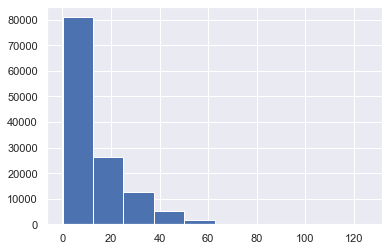

In [29]:
obs['dist'].hist()

In [30]:
# total_tlfd, bin_edges = np.histogram(obs['dist'], bins=50, range=[0,50], weights=obs['final_tripWeight_2015'])
total_tlfd, bin_edges = np.histogram(obs['dist'], bins=50, range=[0,50])
bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2

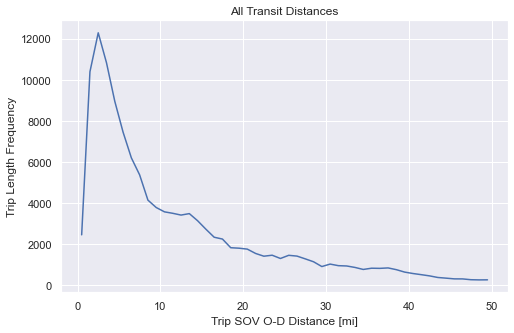

In [31]:
plt.figure(figsize=(8,5))
plt.plot(bin_centers, total_tlfd)
plt.title("All Transit Distances")
plt.xlabel('Trip SOV O-D Distance [mi]')
plt.ylabel('Trip Length Frequency')
plt.show()

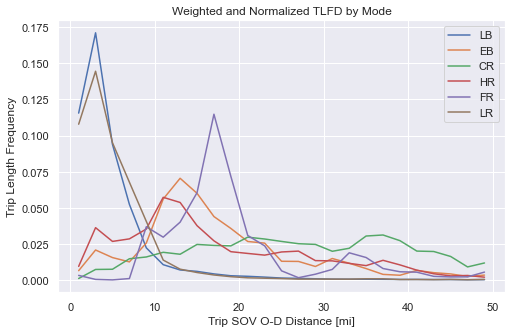

In [32]:
plt.figure(figsize=(8,5))
plt.title("Weighted and Normalized TLFD by Mode")
plt.xlabel('Trip SOV O-D Distance [mi]')
plt.ylabel('Trip Length Frequency')


for tech in obs['SURVEY_MODE'].unique():
    tlfd, bin_edges = np.histogram(
        obs.loc[obs['SURVEY_MODE'] == tech, 'dist'],
        bins=25,
        range=[0,50],
        weights=obs.loc[obs['SURVEY_MODE'] == tech, 'final_tripWeight_2015'],
        density=True
    )
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    plt.plot(bin_centers, tlfd, label=tech)

    
plt.legend()
plt.show()
    

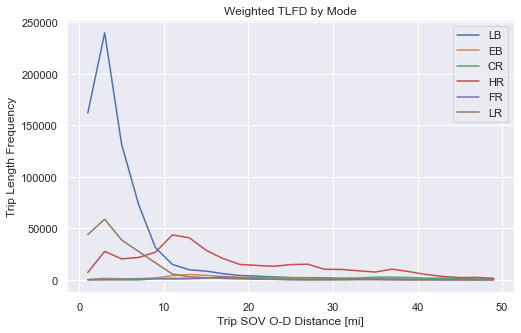

In [33]:
plt.figure(figsize=(8,5))
plt.title("Weighted TLFD by Mode")
plt.xlabel('Trip SOV O-D Distance [mi]')
plt.ylabel('Trip Length Frequency')


for tech in obs['SURVEY_MODE'].unique():
    tlfd, bin_edges = np.histogram(
        obs.loc[obs['SURVEY_MODE'] == tech, 'dist'],
        bins=25,
        range=[0,50],
        weights=obs.loc[obs['SURVEY_MODE'] == tech, 'final_tripWeight_2015'],
        density=False
    )
    bin_centers = bin_edges[:-1] + (bin_edges[1] - bin_edges[0]) / 2
    plt.plot(bin_centers, tlfd, label=tech)

    
plt.legend()
plt.show()
    